# Identifying Disaster Tweets
 
I apply machine learning techniques on Twitter data to identify which tweets relate to genuine disasters. This could be useful, for example, for emergency services or news agencies.

### What am I predicting?

Whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.




### What should I expect the data format to be?

Each sample in the train and test set has the following information:

- The text of a tweet
- A keyword from that tweet (although this may be blank)
- The location the tweet was sent from (may also be blank)

### Files

- train.csv 
- test.csv 

### Columns

- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, model_selection, preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## K Most Occuring Words Sorted by their Frequency


In [3]:
from collections import Counter
  
data_set = train_df["text"] + " "
data_set = data_set.str.cat()
  
# split() returns list of all the words in the string
split_it = data_set.split()
  
# Pass the split_it list to instance of Counter class.
Counter = Counter(split_it)
  
# most_common() produces k frequently encountered
# input values and their respective counts.

vocabulary_size = 10000
most_occuring = Counter.most_common(vocabulary_size)

vocab = [word for (word, count) in most_occuring]



# Vectorize the Data

In [4]:
#CountVectorizer converts a collection of text documents to a matrix of token counts
count_vectorizer = feature_extraction.text.CountVectorizer(vocabulary=vocab)

train_vectors = count_vectorizer.fit_transform(train_df["text"])
test_vectors = count_vectorizer.transform(test_df["text"])

# note that we're NOT using .fit_transform() for test data. Using just .transform() makes sure
# that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.

x_train, x_test, y_train, y_test = train_test_split(train_vectors.todense(), train_df["target"], 
                                                   test_size=0.33, random_state=42)
x_train.shape

(5100, 10000)

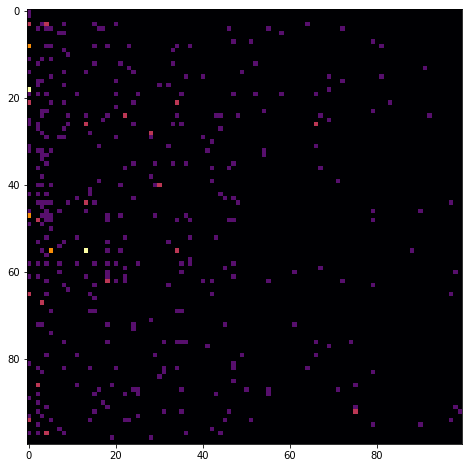

In [5]:
plt.figure(figsize=(8, 8))

plt.imshow(x_train[:100, :100], cmap="inferno")
plt.show()
plt.close()

# RidgeClassifier (Kaggle example)


In [6]:
from sklearn import linear_model, metrics

## Our vectors are really big, so we want to push our model's weights toward 0 
## without completely discounting different words - 
## ridge regression is a good way to do this.
clf = linear_model.RidgeClassifier()
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy is: " + f"{accuracy:.04f}")

f1 = metrics.f1_score(y_test, y_pred)
print("f1 is: " + f"{f1:.04f}")


Accuracy is: 0.7704
f1 is: 0.7225


# GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

clf = GaussianNB()
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy is: " + f"{accuracy:.04f}")

f1 = metrics.f1_score(y_test, y_pred)
print("f1 is: " + f"{f1:.04f}")


# DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

clf = DecisionTreeClassifier(max_leaf_nodes=10) #This takes too long without some limit
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy is: " + f"{accuracy:.04f}")

f1 = metrics.f1_score(y_test, y_pred)
print("f1 is: " + f"{f1:.04f}")

# Simple Neural Network

In [ ]:
# needs vectorized data as input

from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Dense(512, activation="relu", input_shape=(vocabulary_size, )))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    x_train, y_train, 
    epochs=20,
    batch_size=500,
    validation_split=0.2
)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(model.history.history["accuracy"], label="accuracy")
plt.plot(model.history.history["val_accuracy"], label="val_accuracy")
plt.title("Accuracy with Simple Neural Network")
plt.legend()
plt.show()
plt.close()

plt.plot(model.history.history["loss"], label="loss")
plt.plot(model.history.history["val_loss"], label="val_loss")
plt.title("Loss with Simple Neural Network")
plt.legend()
plt.show()
plt.close()

# Neural Networks with Embedding

In [ ]:
x_train = train_df["text"]
y_train = train_df["target"]

x_train[0]

In [ ]:
# working out word length of tweets

lengths = [len(t.split(' ')) for t in train_df["text"]]

plt.hist(lengths, bins=len(set(lengths)))
plt.xlabel('Number of Words')
plt.ylabel('Number of Tweets')
plt.title('Word-Length of Tweets')
plt.show()

# the chart shows that 30 is a reasonable sequence length

sequence_length = 30

In [ ]:
# Tokenizing

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(x_train)
x_train_tokenized = tokenizer.texts_to_sequences(x_train)

x_train_tokenized[0]


In [ ]:
# Padding and Truncating

from tensorflow.keras import preprocessing

x_train_padded = preprocessing.sequence.pad_sequences(
    x_train_tokenized,
    maxlen=sequence_length,
    padding="post",
    truncating="post"
)


In [ ]:
from tensorflow.keras import models, layers

model = models.Sequential()

embedding_size = 16
model.add(layers.Embedding(vocabulary_size, embedding_size, input_length=sequence_length))

model.add(layers.Flatten())
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    x_train_padded, y_train,
    epochs=20,
    batch_size=500,
    validation_split=0.2
)

In [ ]:
plt.plot(model.history.history["accuracy"], label="accuracy")
plt.plot(model.history.history["val_accuracy"], label="val_accuracy")
plt.title("Accuracy with Neural Network + Embedding")
plt.legend()
plt.show()
plt.close()

plt.plot(model.history.history["loss"], label="loss")
plt.plot(model.history.history["val_loss"], label="val_loss")
plt.title("Loss with Neural Network + Embedding")
plt.legend()
plt.show()
plt.close()

# Neural Networks with Embedding & LSTM

In [ ]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Embedding(vocabulary_size, embedding_size, input_length=sequence_length))
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    x_train_padded, y_train,
    epochs=20,
    batch_size=500,
    validation_split=0.2
)

In [ ]:
plt.plot(model.history.history["accuracy"], label="accuracy")
plt.plot(model.history.history["val_accuracy"], label="val_accuracy")
plt.title("Neural Network with Embedding & LSTM")
plt.title("Accuracy with Neural Network + Embedding & LSTM")
plt.legend()
plt.show()
plt.close()

plt.plot(model.history.history["loss"], label="loss")
plt.plot(model.history.history["val_loss"], label="val_loss")
plt.title("Loss with Neural Network + Embedding & LSTM")
plt.legend()
plt.show()
plt.close()